In [59]:
import pandas as pd
import numpy as np 
import ConeccionesSucursales as cs 
import mysql.connector
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
#Definimos la ruta en donde queremos guardar los archivos
ruta_guardar = '/home/estadistico/Documents/Erick/Reportes diarios'
ruta_asig_baz = '/home/estadistico/Documents/Erick/Banco Azteca/Asignacion csv'
ruta_pagos = '/home/estadistico/Documents/Erick'
mes = 20201201
mes2 = 'Diciembre2020'
mes3 = pd.to_datetime('01/12/2020',dayfirst=True)
prim_sem_mes = 49

In [3]:
#Asignamos valores a los parametros"
today = date.today().strftime('%Y%m%d')
now = datetime.now().strftime('%d-%m-%Y %H-%M')
hoy = np.datetime64('today')
ayer = np.datetime64(date.today() - timedelta(1))
today2 = date.today().strftime('%d-%m-%Y')

In [46]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Bradesco

In [10]:
#Lectura pagos Bradesco
pagos_brad = pd.read_excel(''+ruta_pagos+'/'+str(mes2)+'/Bradesco/Pagos/ENRIQUEZ Acumulado de pagos Diciembre de 2020.xlsx',converters={'NUMERO_CUENTA':str})
pagos_brad = pagos_brad.iloc[:,0:9]
#pagos_brad = pagos_brad.drop_duplicates()
pagos_brad2 = pagos_brad.loc[pagos_brad['FECHA_PAGO']>=mes3]
#pagos_brad2 = pd.pivot_table(pagos_brad,index=['TIPO_ASIGANCION'],values=['MONTO'],aggfunc=np.sum,margins=True)
#pagos_brad2 = pd.DataFrame(pagos_brad2.to_records())
pagos_brad2.head(1)

,PRODUCTO,NUMERO_TARJETA,NUMERO_CUENTA,SALDO_TOTAL,PAGO_DESCUENTO,MONTO,FECHA_PAGO,CORTE,TIPO_ASIGANCION
0,BC,4463511467169015,0004463511467169000,4375.96,2976.0,2.0,2020-12-01,10,C0 4PV


In [12]:
#Leemos la asignacion del mes correspondiente c0
asignacion_c0 = pd.read_excel('/home/estadistico/Documents/Erick/Bradesco/Asignacion_c0/ASIGNACION C0 '+mes2+'.xlsx',converters={'NUMERO_CUENTA':str})
asignacion_c0 = asignacion_c0.iloc[:,[0,2,3,8,10,11,]]
asignacion_c0.head(1)

,CODIGO_ORG,NUMERO_CUENTA,NUMERO_TARJETA,ESTADO,RFC,SALDO_TOTAL
0,PLCC,0002869008477675000,2869008477675028,PUEBLA,TAIF780217L5801,31.36


In [15]:
#Leemos la asignacion del mes corresponiente extra
asignacion_extra = pd.read_excel('/home/estadistico/Documents/Erick/Bradesco/Asignacion_extra/XLSX/ASIGNACION EXTRA '+mes2+'.xlsx',converters={'NUMERO DE CUENTA':str})
asignacion_extra = asignacion_extra.iloc[:,[0,2,3,9,5,25]]
asignacion_extra.columns = ['CODIGO_ORG','NUMERO_CUENTA','NUMERO_TARJETA','ESTADO','RFC','SALDO_TOTAL']
asignacion_extra.head(1)

,CODIGO_ORG,NUMERO_CUENTA,NUMERO_TARJETA,ESTADO,RFC,SALDO_TOTAL
0,PL C&A,0002869008003304000,2869008003304010,PUEBLA,MAHS59021892901,17244.86


In [73]:
#Leemos el codigo correcto
prod_correcto = pd.read_excel('/home/estadistico/Documents/Erick/Bradesco/CODIGOS_PRO.xlsx')

In [16]:
#Union de asignaciones extra y c0
asignacion_brad = pd.concat([asignacion_c0,asignacion_extra],ignore_index=True)

In [48]:
#Consolidado de asignacion con pagos
consolidado_pagos_brad = pd.merge(asignacion_brad,pagos_brad2,how='left',on=['NUMERO_CUENTA'])
consolidado_pagos_brad['NACIMIENTO'] = consolidado_pagos_brad['RFC'].str[4:10]
consolidado_pagos_brad['NACIMIENTO'] = np.where(consolidado_pagos_brad['NACIMIENTO'].str[:2].map(int) > 25,'19'+consolidado_pagos_brad['NACIMIENTO'],'20'+consolidado_pagos_brad['NACIMIENTO'])
consolidado_pagos_brad['NACIMIENTO'] = [datetime.strptime(y, '%Y%m%d').strftime('%d/%m/%Y') for y in consolidado_pagos_brad['NACIMIENTO']]
consolidado_pagos_brad['NACIMIENTO'] = pd.to_datetime(consolidado_pagos_brad['NACIMIENTO'],dayfirst=True)
consolidado_pagos_brad['EDAD'] = [calculate_age(x) for x in consolidado_pagos_brad['NACIMIENTO']]
consolidado_pagos_brad.head(1)

,CODIGO_ORG,NUMERO_CUENTA,NUMERO_TARJETA_x,ESTADO,RFC,SALDO_TOTAL_x,PRODUCTO,NUMERO_TARJETA_y,SALDO_TOTAL_y,PAGO_DESCUENTO,MONTO,FECHA_PAGO,CORTE,TIPO_ASIGANCION,NACIMIENTO,EDAD
0,PLCC,0002869008477675000,2869008477675028,PUEBLA,TAIF780217L5801,31.36,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,1978-02-17,42


In [74]:
#Nos quedamos unicamente con los pagos
consolidado_pagos_brad = pd.merge(consolidado_pagos_brad,prod_correcto,how='left',on='CODIGO_ORG')
pagos_brad_union = consolidado_pagos_brad.dropna(subset=['MONTO'])

In [109]:
pagos_brad_union2 = pagos_brad_union[np.abs(pagos_brad_union['MONTO']-pagos_brad_union['MONTO'].mean())<=(3*pagos_brad_union['MONTO'].std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
pagos_brad_union2 = pagos_brad_union2[~(np.abs(pagos_brad_union2['MONTO']-pagos_brad_union2['MONTO'].mean())>(3*pagos_brad_union2['MONTO'].std()))]

In [97]:
#Vemos los pagos que se dieron por edad
pagos_edad = pd.pivot_table(pagos_brad_union2,index=['EDAD'],values=['MONTO'],aggfunc=[np.sum,np.mean])
pagos_edad = pd.DataFrame(pagos_edad.to_records())
pagos_edad.columns = ['EDAD','SUMA_PAGO','PROMEDIO_PAGO']
pagos_edad.head(1)

,EDAD,SUMA_PAGO,PROMEDIO_PAGO
0,19,39622.89,1200.693636


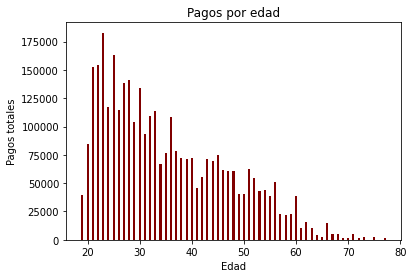

In [98]:
#Graficamos la suma de pagos
plt.bar(pagos_edad['EDAD'],pagos_edad['SUMA_PAGO'],color ='maroon',width = 0.4)

plt.xlabel("Edad") 
plt.ylabel("Pagos totales") 
plt.title("Pagos por edad") 
plt.savefig('/home/estadistico/Pictures/Pagos edad '+mes2+'.png')
plt.show()

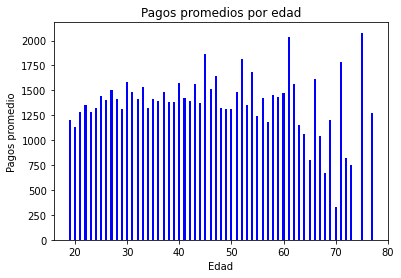

In [99]:
#Graficamos el promedio de pagos
plt.bar(pagos_edad['EDAD'],pagos_edad['PROMEDIO_PAGO'],color ='blue',width = 0.4)

plt.xlabel("Edad") 
plt.ylabel("Pagos promedio") 
plt.title("Pagos promedios por edad") 
plt.savefig('/home/estadistico/Pictures/Pagos promedio edad '+mes2+'.png')
plt.show()

In [108]:
pagos_org = pd.pivot_table(pagos_brad_union2,index=['PRODUCTO'],values=['MONTO'],aggfunc=[np.sum,np.mean,np.max,np.min])
pagos_org = pd.DataFrame(pagos_org.to_records())
pagos_org.columns = ['PRODUCTO','SUMA_PAGOS','MEAN_PAGOS','MAX_PAGO','MIN_PAGO']
pagos_org = pagos_org.sort_values('SUMA_PAGOS',ascending=False,ignore_index=True)
pagos_org.head(1)

,PRODUCTO,SUMA_PAGOS,MEAN_PAGOS,MAX_PAGO,MIN_PAGO
0,PLCC,1283188.27,1181.572993,5146.0,0.56


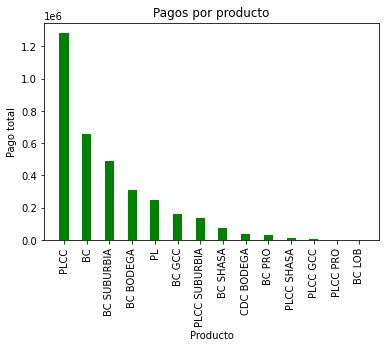

In [101]:
plt.bar(pagos_org['PRODUCTO'],pagos_org['SUMA_PAGOS'],color='green',width=0.4)

plt.xlabel('Producto')
plt.ylabel('Pago total')
plt.title('Pagos por producto')
plt.xticks(rotation=90)
plt.show()

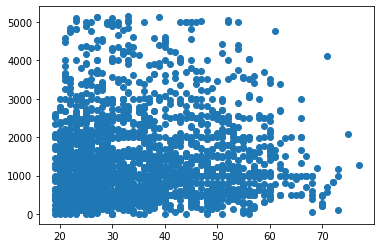

In [107]:
plt.scatter(pagos_brad_union2['EDAD'],pagos_brad_union2['MONTO'])

In [113]:
#Hacemos el analisis por estado
pagos_estado = pd.pivot_table(pagos_brad_union2,index=['ESTADO'],values=['MONTO'],aggfunc=[np.sum])
pagos_estado = pd.DataFrame(pagos_estado.to_records())
pagos_estado.columns = ['ESTADO','SUMA_MONTO']
pagos_estado = pagos_estado.sort_values('SUMA_MONTO',ascending=False,ignore_index=True)

<BarContainer object of 31 artists>

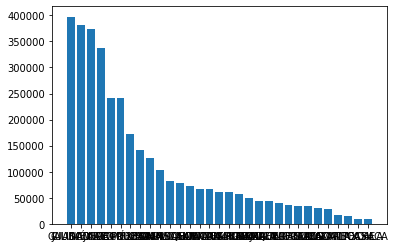

In [114]:
#Graficamos 
plt.bar(pagos_estado['ESTADO'],pagos_estado['SUMA_MONTO'])

plt.xlabel('Estado')
plt.ylabel('Monto')
plt.title('Pagos por estado')